In [1]:
# ========================================
# NOTEBOOK 0: Setup & Installation
# ========================================

# Install required packages
!pip install sentence-transformers
!pip install aif360
!pip install datasets

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Environment ready")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.8 MB/s eta 0:00:00
✓ Environment ready


In [2]:
# ========================================
# NOTEBOOK 1: Data Acquisition & Processing
# Run this in Google Colab
# ========================================

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
import pickle

# ========================================
# PART 1: Load Job Postings Data
# ========================================

print("=" * 60)
print("PART 1: Loading Job Postings")
print("=" * 60)

# Option A: Upload CSV manually to Colab
# from google.colab import files
# uploaded = files.upload()

# Option B: Load from Kaggle (recommended)
# You'll need to upload kaggle.json first
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d ravindrasinghrana/job-description-dataset

# For this example, we'll create synthetic job postings
# REPLACE THIS with your actual dataset

jobs_data = {
    'job_id': range(1000),
    'title': ['Software Engineer', 'Data Scientist', 'Backend Developer',
              'Frontend Developer', 'DevOps Engineer'] * 200,
    'description': [
        'Looking for experienced software engineer with strong Python skills and Bachelor degree',
        'Seeking data scientist with Masters degree, ML experience, statistical background',
        'Backend developer needed, 3+ years experience, degree preferred but not required',
        'Frontend engineer with modern frameworks, portfolio of projects required',
        'DevOps engineer with cloud experience, certifications or degree required'
    ] * 200,
    'required_experience': np.random.choice(['0-2', '2-5', '5-10', '10+'], 1000),
    'industry': np.random.choice(['Tech', 'Finance', 'Healthcare', 'Retail'], 1000)
}

df_jobs = pd.DataFrame(jobs_data)

print(f"✓ Loaded {len(df_jobs)} job postings")
print(f"Sample:\n{df_jobs.head()}\n")

# ========================================
# PART 2: Load Candidate Data
# ========================================

print("=" * 60)
print("PART 2: Creating Candidate Profiles")
print("=" * 60)

# Synthetic candidate data (replace with Stack Overflow survey)
# Stack Overflow survey: https://insights.stackoverflow.com/survey

np.random.seed(42)
n_candidates = 2000

candidates_data = {
    'candidate_id': range(n_candidates),
    'education': np.random.choice([
        'PhD', 'Master\'s degree', 'Bachelor\'s degree',
        'Associate degree', 'Bootcamp', 'Self-taught'
    ], n_candidates, p=[0.05, 0.20, 0.40, 0.10, 0.15, 0.10]),
    'years_experience': np.random.exponential(5, n_candidates).clip(0, 20),
    'role': np.random.choice([
        'Software Engineer', 'Data Scientist', 'Backend Developer',
        'Frontend Developer', 'DevOps Engineer'
    ], n_candidates),
    'skills': [
        'Python, SQL, Git, AWS',
        'Python, R, ML, Statistics, TensorFlow',
        'Java, Spring, Docker, PostgreSQL',
        'React, JavaScript, CSS, HTML',
        'Kubernetes, Terraform, CI/CD, AWS'
    ] * 400
}

df_candidates = pd.DataFrame(candidates_data)

# Map education to tiers
education_mapping = {
    'PhD': 'high',
    'Master\'s degree': 'high',
    'Bachelor\'s degree': 'mid',
    'Associate degree': 'low',
    'Bootcamp': 'low',
    'Self-taught': 'low'
}

df_candidates['education_tier'] = df_candidates['education'].map(education_mapping)

print(f"✓ Created {len(df_candidates)} candidate profiles")
print(f"\nEducation distribution:\n{df_candidates['education_tier'].value_counts()}\n")

# ========================================
# PART 3: Create Experience-Role Strata
# ========================================

print("=" * 60)
print("PART 3: Defining Equivalence Strata")
print("=" * 60)

# Create experience bands
df_candidates['experience_band'] = pd.cut(
    df_candidates['years_experience'],
    bins=[0, 2, 5, 10, 20],
    labels=['junior', 'mid', 'senior', 'lead']
)

# Create strata: role + experience
df_candidates['stratum'] = (
    df_candidates['role'] + '_' +
    df_candidates['experience_band'].astype(str)
)

print("✓ Created strata for equivalence enforcement")
print(f"Number of unique strata: {df_candidates['stratum'].nunique()}")
print(f"\nSample strata counts:\n{df_candidates['stratum'].value_counts().head(10)}\n")

# Filter out strata with too few samples per education tier
stratum_counts = df_candidates.groupby(['stratum', 'education_tier']).size().unstack(fill_value=0)
valid_strata = stratum_counts[(stratum_counts >= 10).all(axis=1)].index

# Store original indices before filtering
df_candidates['original_index'] = df_candidates.index

df_candidates = df_candidates[df_candidates['stratum'].isin(valid_strata)].reset_index(drop=True)

print(f"✓ Filtered to {len(valid_strata)} strata with sufficient samples")
print(f"Final candidate count: {len(df_candidates)}\n")

# ========================================
# PART 4: Generate Embeddings
# ========================================

print("=" * 60)
print("PART 4: Generating Text Embeddings")
print("=" * 60)

# Load sentence transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Loaded embedding model\n")

# Embed job descriptions
print("Embedding job descriptions...")
job_embeddings = model.encode(
    df_jobs['description'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"✓ Generated embeddings: {job_embeddings.shape}\n")

# Embed candidate skills
print("Embedding candidate skills...")
candidate_embeddings = model.encode(
    df_candidates['skills'].tolist(),
    show_progress_bar=True,
    batch_size=32
)
print(f"✓ Generated embeddings: {candidate_embeddings.shape}")

# Create a mapping from current index to embedding index
df_candidates['embedding_idx'] = range(len(df_candidates))
print(f"✓ Created embedding index mapping\n")

# ========================================
# PART 5: Compute Matching Scores
# ========================================

print("=" * 60)
print("PART 5: Computing Similarity Scores")
print("=" * 60)

# For each candidate, compute similarity to all jobs in their role
matching_results = []

for idx, candidate in df_candidates.iterrows():
    # Get jobs matching candidate's role
    role_jobs = df_jobs[df_jobs['title'] == candidate['role']]

    if len(role_jobs) == 0:
        continue

    # Get candidate embedding using the embedding_idx
    emb_idx = candidate['embedding_idx']
    cand_emb = candidate_embeddings[emb_idx].reshape(1, -1)

    # Get job embeddings for this role
    job_indices = role_jobs.index
    role_job_embeddings = job_embeddings[job_indices]

    # Compute similarities
    similarities = cosine_similarity(cand_emb, role_job_embeddings)[0]

    # Take max similarity as the matching score
    max_similarity = similarities.max()
    best_job_idx = job_indices[similarities.argmax()]

    matching_results.append({
        'candidate_id': candidate['candidate_id'],
        'best_job_id': df_jobs.loc[best_job_idx, 'job_id'],
        'match_score': max_similarity,
        'education_tier': candidate['education_tier'],
        'years_experience': candidate['years_experience'],
        'stratum': candidate['stratum'],
        'role': candidate['role']
    })

df_matches = pd.DataFrame(matching_results)

print(f"✓ Computed {len(df_matches)} candidate-job matches")
print(f"\nMatch score statistics:\n{df_matches['match_score'].describe()}\n")

# ========================================
# PART 6: Save Processed Data
# ========================================

print("=" * 60)
print("PART 6: Saving Processed Data")
print("=" * 60)

# Save to pickle for next notebook
with open('processed_data.pkl', 'wb') as f:
    pickle.dump({
        'df_jobs': df_jobs,
        'df_candidates': df_candidates,
        'df_matches': df_matches,
        'job_embeddings': job_embeddings,
        'candidate_embeddings': candidate_embeddings
    }, f)

print("✓ Saved processed data to 'processed_data.pkl'")
print("\n" + "=" * 60)
print("NOTEBOOK 1 COMPLETE")
print("=" * 60)
print("Next: Run Notebook 2 (Exploratory Analysis)")

PART 1: Loading Job Postings
✓ Loaded 1000 job postings
Sample:
   job_id               title  \
0       0   Software Engineer   
1       1      Data Scientist   
2       2   Backend Developer   
3       3  Frontend Developer   
4       4     DevOps Engineer   

                                         description required_experience  \
0  Looking for experienced software engineer with...                 2-5   
1  Seeking data scientist with Masters degree, ML...                 2-5   
2  Backend developer needed, 3+ years experience,...                 2-5   
3  Frontend engineer with modern frameworks, port...                 2-5   
4  DevOps engineer with cloud experience, certifi...                 2-5   

     industry  
0      Retail  
1  Healthcare  
2      Retail  
3  Healthcare  
4     Finance  

PART 2: Creating Candidate Profiles
✓ Created 2000 candidate profiles

Education distribution:
education_tier
mid     774
low     699
high    527
Name: count, dtype: int64

PART 3: De

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✓ Loaded embedding model

Embedding job descriptions...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

✓ Generated embeddings: (1000, 384)

Embedding candidate skills...


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

✓ Generated embeddings: (1960, 384)
✓ Created embedding index mapping

PART 5: Computing Similarity Scores
✓ Computed 1960 candidate-job matches

Match score statistics:
count    1960.000000
mean        0.173367
std         0.100476
min         0.035292
25%         0.097815
50%         0.149680
75%         0.222491
max         0.376948
Name: match_score, dtype: float64

PART 6: Saving Processed Data
✓ Saved processed data to 'processed_data.pkl'

NOTEBOOK 1 COMPLETE
Next: Run Notebook 2 (Exploratory Analysis)


✓ Loaded processed data

PART 1: Education Distribution Analysis


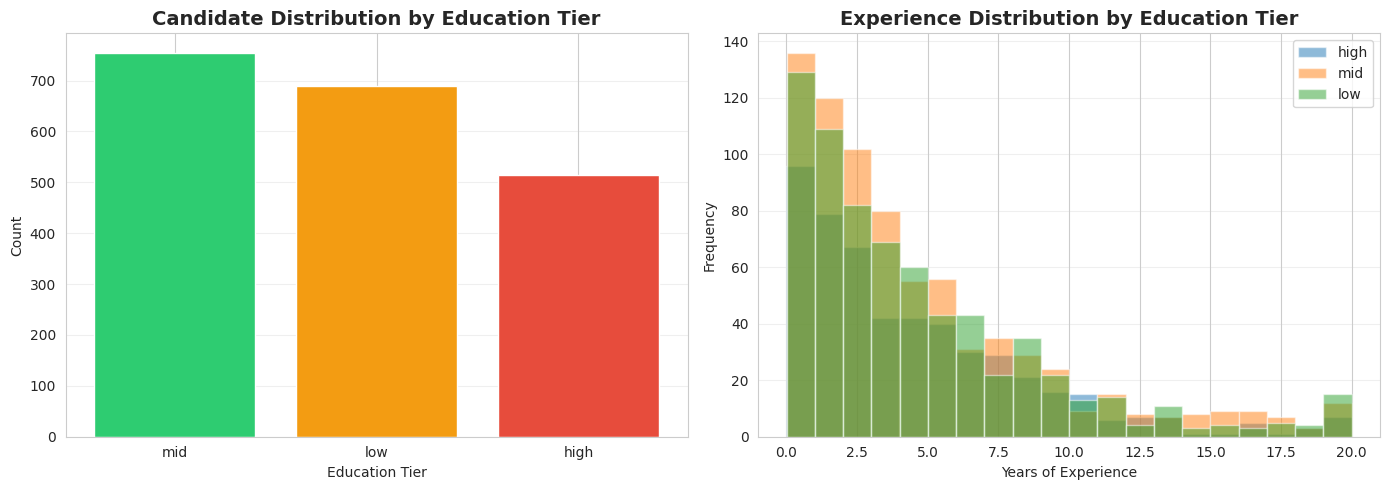


Education tier distribution:
education_tier
mid     755
low     690
high    515
Name: count, dtype: int64

Experience by tier:
                count      mean       std       min       25%       50%  \
education_tier                                                            
high            515.0  4.557713  4.179328  0.000058  1.383488  3.328930   
low             690.0  4.696368  4.459406  0.009971  1.438975  3.343435   
mid             755.0  4.693195  4.492414  0.006773  1.429702  3.235489   

                     75%   max  
education_tier                  
high            6.579397  20.0  
low             6.591772  20.0  
mid             6.531190  20.0  

PART 2: Checking Equivalence Within Strata
✓ Analyzed 19 strata

Strata with good equivalence (exp_range < 2 years):
17 / 19

Sample strata equivalence check:
                     stratum  n_tiers  total_candidates  exp_range
0      Data Scientist_junior        3               143   0.215825
1     DevOps Engineer_junior        3

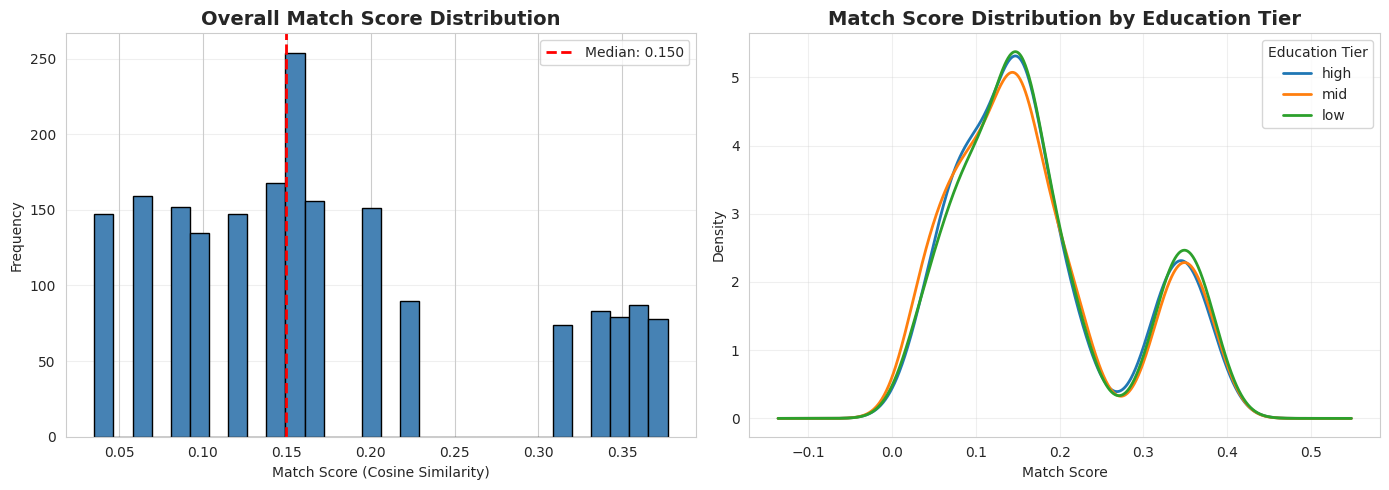


Match score statistics by education tier:
                count      mean       std       min       25%       50%  \
education_tier                                                            
high            515.0  0.173472  0.098832  0.035292  0.097815  0.149680   
low             690.0  0.176676  0.100874  0.035292  0.097815  0.155101   
mid             755.0  0.170272  0.101256  0.035292  0.091124  0.149680   

                     75%       max  
education_tier                      
high            0.203131  0.376948  
low             0.222491  0.376948  
mid             0.203131  0.376948  

ANOVA test (do scores differ across tiers?):
F-statistic: 0.7323, p-value: 0.4809
→ No significant difference in scores across tiers

PART 4: Correlation Analysis


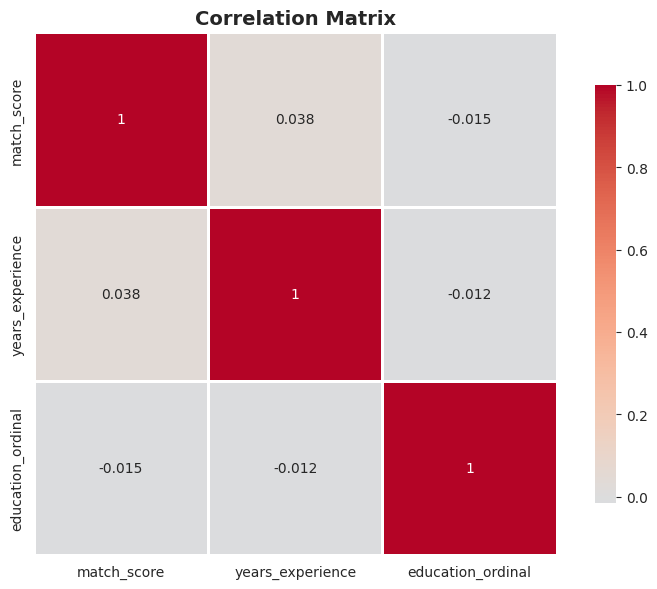


Correlation matrix:
                   match_score  years_experience  education_ordinal
match_score           1.000000          0.037727          -0.014531
years_experience      0.037727          1.000000          -0.011617
education_ordinal    -0.014531         -0.011617           1.000000

PART 5: Within-Stratum Equivalence (Sample)


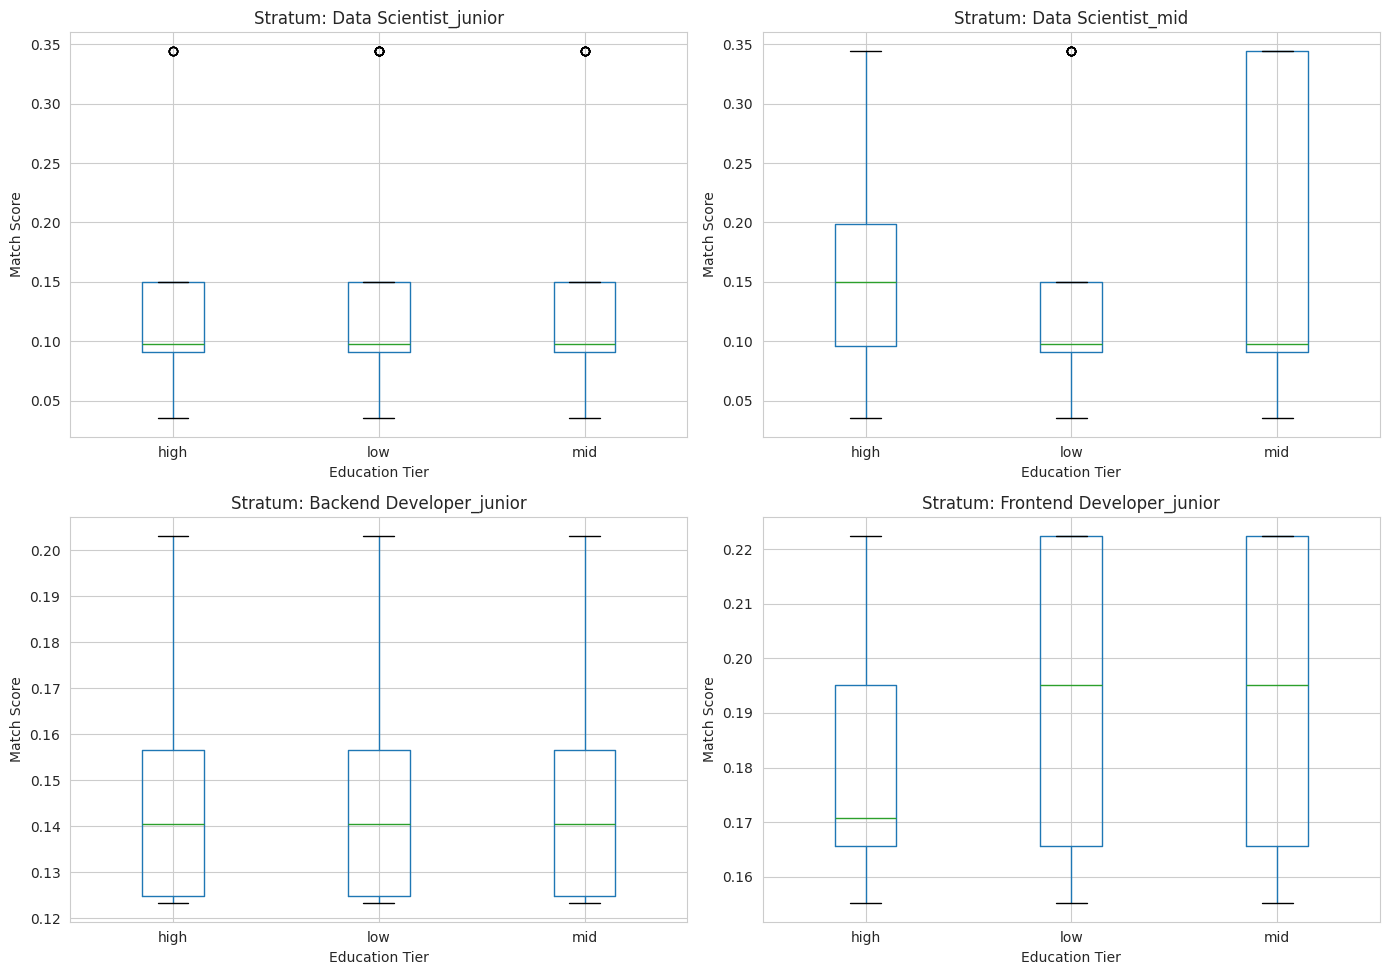

✓ Visualized score distributions within sample strata

EXPLORATORY ANALYSIS SUMMARY

Key Findings:
1. Sample size: 1960 candidate-job matches
2. Education tiers: {'mid': 755, 'low': 690, 'high': 515}
3. Unique strata: 19
4. Match score range: 0.035 - 0.377
5. Score correlation with education: -0.015

Equivalence Check:
- Strata with good equivalence: 17 / 19
- This ensures we're comparing "apples to apples"

Next Steps:
- Define outcome variable (high match threshold)
- Compute fairness metrics within strata
- Test for systematic bias

NOTEBOOK 2 COMPLETE
Next: Run Notebook 3 (Bias Measurement)


In [3]:
# ========================================
# NOTEBOOK 2: Exploratory Analysis & Equivalence Checks
# Run this in Google Colab after Notebook 1
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy import stats

# Load processed data
with open('processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

df_matches = data['df_matches']
df_candidates = data['df_candidates']

print("✓ Loaded processed data\n")

# ========================================
# PART 1: Education Distribution
# ========================================

print("=" * 60)
print("PART 1: Education Distribution Analysis")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Education tier counts
ed_counts = df_matches['education_tier'].value_counts()
axes[0].bar(ed_counts.index, ed_counts.values, color=['#2ecc71', '#f39c12', '#e74c3c'])
axes[0].set_title('Candidate Distribution by Education Tier', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Education Tier')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Experience distribution by education
for tier in ['high', 'mid', 'low']:
    subset = df_matches[df_matches['education_tier'] == tier]
    axes[1].hist(subset['years_experience'], bins=20, alpha=0.5, label=tier)

axes[1].set_title('Experience Distribution by Education Tier', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Years of Experience')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nEducation tier distribution:")
print(ed_counts)
print(f"\nExperience by tier:")
print(df_matches.groupby('education_tier')['years_experience'].describe())

# ========================================
# PART 2: Equivalence Checks Within Strata
# ========================================

print("\n" + "=" * 60)
print("PART 2: Checking Equivalence Within Strata")
print("=" * 60)

# For each stratum, check if education tiers have similar experience
strata_equivalence = []

for stratum in df_matches['stratum'].unique():
    subset = df_matches[df_matches['stratum'] == stratum]

    # Get experience by education tier
    exp_by_tier = subset.groupby('education_tier')['years_experience'].agg(['mean', 'std', 'count'])

    if len(exp_by_tier) >= 2:  # Need at least 2 tiers to compare
        strata_equivalence.append({
            'stratum': stratum,
            'n_tiers': len(exp_by_tier),
            'total_candidates': len(subset),
            'exp_range': exp_by_tier['mean'].max() - exp_by_tier['mean'].min()
        })

df_strata_check = pd.DataFrame(strata_equivalence)

print(f"✓ Analyzed {len(df_strata_check)} strata")
print(f"\nStrata with good equivalence (exp_range < 2 years):")
print(f"{(df_strata_check['exp_range'] < 2).sum()} / {len(df_strata_check)}")
print(f"\nSample strata equivalence check:")
print(df_strata_check.head(10))

# ========================================
# PART 3: Match Score Distributions
# ========================================

print("\n" + "=" * 60)
print("PART 3: Match Score Distribution Analysis")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall score distribution
axes[0].hist(df_matches['match_score'], bins=30, color='steelblue', edgecolor='black')
axes[0].axvline(df_matches['match_score'].median(), color='red',
                linestyle='--', linewidth=2, label=f"Median: {df_matches['match_score'].median():.3f}")
axes[0].set_title('Overall Match Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Match Score (Cosine Similarity)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Score distribution by education tier (KDE)
for tier in ['high', 'mid', 'low']:
    subset = df_matches[df_matches['education_tier'] == tier]
    subset['match_score'].plot.kde(ax=axes[1], label=tier, linewidth=2)

axes[1].set_title('Match Score Distribution by Education Tier', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Match Score')
axes[1].set_ylabel('Density')
axes[1].legend(title='Education Tier')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMatch score statistics by education tier:")
print(df_matches.groupby('education_tier')['match_score'].describe())

# Statistical test: do scores differ across tiers?
high_scores = df_matches[df_matches['education_tier'] == 'high']['match_score']
mid_scores = df_matches[df_matches['education_tier'] == 'mid']['match_score']
low_scores = df_matches[df_matches['education_tier'] == 'low']['match_score']

f_stat, p_value = stats.f_oneway(high_scores, low_scores, mid_scores)
print(f"\nANOVA test (do scores differ across tiers?):")
print(f"F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("→ Scores differ significantly across education tiers")
else:
    print("→ No significant difference in scores across tiers")

# ========================================
# PART 4: Correlation Analysis
# ========================================

print("\n" + "=" * 60)
print("PART 4: Correlation Analysis")
print("=" * 60)

# Encode education as ordinal
education_ordinal = {'low': 0, 'mid': 1, 'high': 2}
df_matches['education_ordinal'] = df_matches['education_tier'].map(education_ordinal)

correlations = df_matches[['match_score', 'years_experience', 'education_ordinal']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation matrix:")
print(correlations)

# ========================================
# PART 5: Sample Equivalence Check (Visual)
# ========================================

print("\n" + "=" * 60)
print("PART 5: Within-Stratum Equivalence (Sample)")
print("=" * 60)

# Pick a few representative strata to visualize
sample_strata = df_matches['stratum'].value_counts().head(4).index

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, stratum in enumerate(sample_strata):
    subset = df_matches[df_matches['stratum'] == stratum]

    # Box plot of match scores by education tier
    subset.boxplot(column='match_score', by='education_tier', ax=axes[i])
    axes[i].set_title(f'Stratum: {stratum}', fontsize=12)
    axes[i].set_xlabel('Education Tier')
    axes[i].set_ylabel('Match Score')
    axes[i].get_figure().suptitle('')  # Remove default title

plt.tight_layout()
plt.show()

print("✓ Visualized score distributions within sample strata")

# ========================================
# SUMMARY
# ========================================

print("\n" + "=" * 60)
print("EXPLORATORY ANALYSIS SUMMARY")
print("=" * 60)

print(f"""
Key Findings:
1. Sample size: {len(df_matches)} candidate-job matches
2. Education tiers: {df_matches['education_tier'].value_counts().to_dict()}
3. Unique strata: {df_matches['stratum'].nunique()}
4. Match score range: {df_matches['match_score'].min():.3f} - {df_matches['match_score'].max():.3f}
5. Score correlation with education: {correlations.loc['match_score', 'education_ordinal']:.3f}

Equivalence Check:
- Strata with good equivalence: {(df_strata_check['exp_range'] < 2).sum()} / {len(df_strata_check)}
- This ensures we're comparing "apples to apples"

Next Steps:
- Define outcome variable (high match threshold)
- Compute fairness metrics within strata
- Test for systematic bias
""")

print("=" * 60)
print("NOTEBOOK 2 COMPLETE")
print("=" * 60)
print("Next: Run Notebook 3 (Bias Measurement)")

✓ Loaded processed data

PART 1: Defining Outcome Variable
Threshold: Top 20%
  Cutoff score: 0.3196
  Selection rate: 20.46%
  Selected: 401 / 1960

Threshold: Top 30%
  Cutoff score: 0.1952
  Selection rate: 32.55%
  Selected: 638 / 1960

Threshold: Top 40%
  Cutoff score: 0.1657
  Selection rate: 40.71%
  Selected: 798 / 1960

Threshold: Top 50%
  Cutoff score: 0.1497
  Selection rate: 53.67%
  Selected: 1052 / 1960

→ Using 30% threshold as primary outcome

PART 2: Computing Fairness Metrics (Manual)
OVERALL FAIRNESS METRICS
----------------------------------------

Selection Rates by Education Tier:
                    mean  sum  count
education_tier                      
high            0.316505  163    515
low             0.330435  228    690
mid             0.327152  247    755

Statistical Parity Difference (high - low): -0.0139
  → Positive = high-ed favored, Negative = low-ed favored

Disparate Impact Ratio (low / high): 1.0440
  → < 0.8 is problematic (80% rule)
  → Current

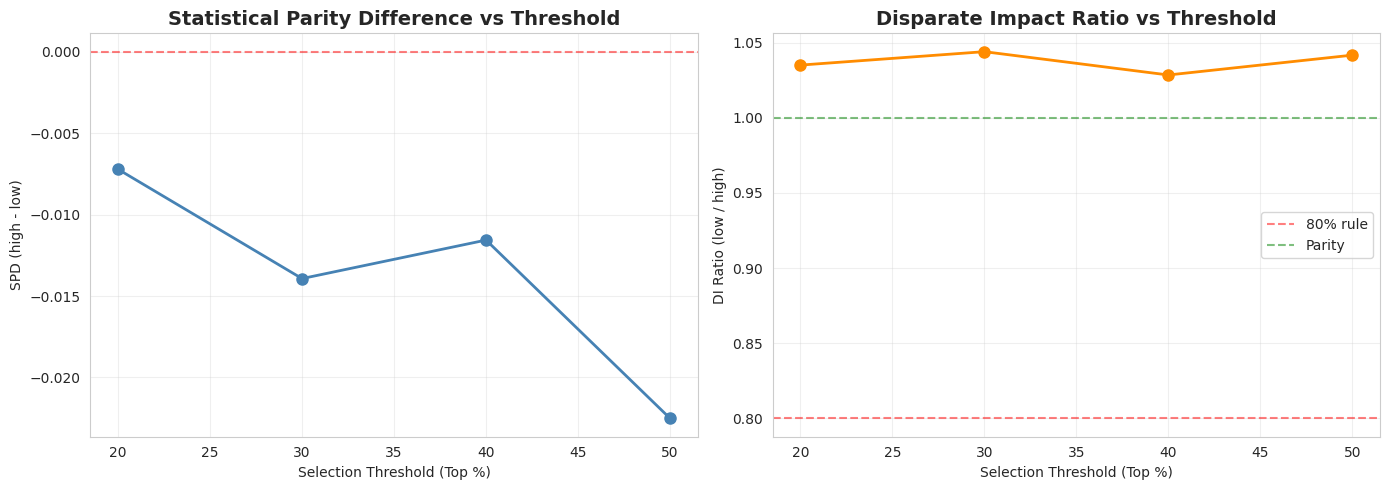


✓ Bias is STABLE across thresholds

PART 5: Fairness Visualization Dashboard


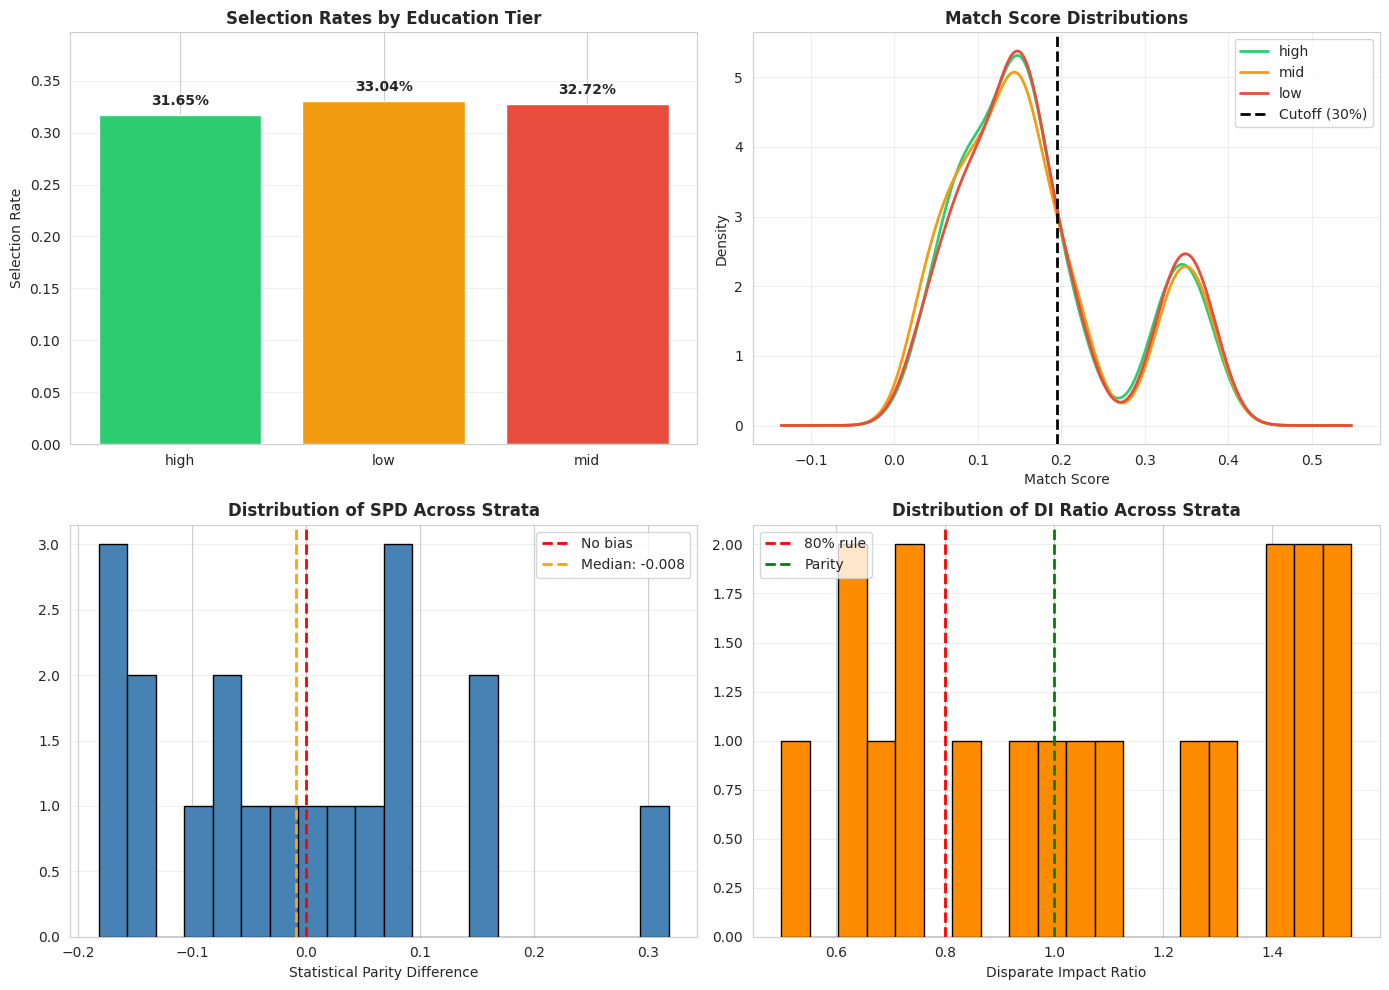


✓ Saved bias measurement results to 'bias_results.pkl'

BIAS MEASUREMENT SUMMARY

Key Findings:

1. Overall Bias (Pooled Analysis):
   - SPD (high - low): -0.0139
   - DI Ratio (low / high): 1.0440
   - Status: PASS (≥0.8)

2. Within-Stratum Analysis:
   - Strata analyzed: 19
   - Median SPD: -0.0083
   - Median DI: 1.0541
   - Problematic strata (DI < 0.8): 6 (31.6%)

3. Threshold Sensitivity:
   - Tested: 20%, 30%, 40%, 50%
   - DI Ratio std: 0.0070
   - Conclusion: Bias is stable

Interpretation:
→ No strong systematic bias detected



Next Steps:
- Test if modeling amplifies this bias (Notebook 4)
- Investigate language patterns driving disparities

NOTEBOOK 3 COMPLETE
Next: Run Notebook 4 (Modeling & Bias Amplification)


In [4]:
# ========================================
# NOTEBOOK 3: Bias Measurement & Fairness Metrics
# Run this in Google Colab after Notebook 2
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load processed data
with open('processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

df_matches = data['df_matches']

print("✓ Loaded processed data\n")

# ========================================
# PART 1: Define Outcome Variable
# ========================================

print("=" * 60)
print("PART 1: Defining Outcome Variable")
print("=" * 60)

# Test multiple thresholds for sensitivity analysis
thresholds = [20, 30, 40, 50]  # percentiles

threshold_results = []

for thresh_pct in thresholds:
    # Define cutoff (top X% of scores)
    cutoff = np.percentile(df_matches['match_score'], 100 - thresh_pct)

    # Create binary outcome
    df_matches[f'high_match_{thresh_pct}'] = (df_matches['match_score'] >= cutoff).astype(int)

    selection_rate = df_matches[f'high_match_{thresh_pct}'].mean()

    threshold_results.append({
        'threshold_pct': thresh_pct,
        'cutoff_score': cutoff,
        'selection_rate': selection_rate,
        'n_selected': df_matches[f'high_match_{thresh_pct}'].sum()
    })

    print(f"Threshold: Top {thresh_pct}%")
    print(f"  Cutoff score: {cutoff:.4f}")
    print(f"  Selection rate: {selection_rate:.2%}")
    print(f"  Selected: {df_matches[f'high_match_{thresh_pct}'].sum()} / {len(df_matches)}\n")

# Use 30% as primary threshold for analysis
PRIMARY_THRESHOLD = 30
outcome_col = f'high_match_{PRIMARY_THRESHOLD}'

print(f"→ Using {PRIMARY_THRESHOLD}% threshold as primary outcome\n")

# ========================================
# PART 2: Manual Fairness Metrics
# ========================================

print("=" * 60)
print("PART 2: Computing Fairness Metrics (Manual)")
print("=" * 60)

def compute_fairness_metrics_manual(df, outcome_col, protected_col='education_tier'):
    """
    Compute fairness metrics manually (no AIF360 dependency)
    """
    results = {}

    # Selection rates by group
    rates = df.groupby(protected_col)[outcome_col].agg(['mean', 'sum', 'count'])
    results['selection_rates'] = rates

    # Statistical Parity Difference (SPD)
    # SPD = P(Y=1|high_ed) - P(Y=1|low_ed)
    high_rate = rates.loc['high', 'mean']
    low_rate = rates.loc['low', 'mean']
    results['spd'] = high_rate - low_rate

    # Disparate Impact Ratio (DI)
    # DI = P(Y=1|low_ed) / P(Y=1|high_ed)
    # Ideal = 1.0, < 0.8 is concerning (80% rule)
    results['di_ratio'] = low_rate / high_rate if high_rate > 0 else np.nan

    # Mid-tier comparisons
    if 'mid' in rates.index:
        mid_rate = rates.loc['mid', 'mean']
        results['spd_high_mid'] = high_rate - mid_rate
        results['spd_mid_low'] = mid_rate - low_rate
        results['di_ratio_mid_high'] = mid_rate / high_rate if high_rate > 0 else np.nan
        results['di_ratio_low_mid'] = low_rate / mid_rate if mid_rate > 0 else np.nan

    return results

# Compute overall metrics
overall_metrics = compute_fairness_metrics_manual(df_matches, outcome_col)

print("OVERALL FAIRNESS METRICS")
print("-" * 40)
print("\nSelection Rates by Education Tier:")
print(overall_metrics['selection_rates'])
print(f"\nStatistical Parity Difference (high - low): {overall_metrics['spd']:.4f}")
print(f"  → Positive = high-ed favored, Negative = low-ed favored")
print(f"\nDisparate Impact Ratio (low / high): {overall_metrics['di_ratio']:.4f}")
print(f"  → < 0.8 is problematic (80% rule)")
print(f"  → Current: {'PASS ✓' if overall_metrics['di_ratio'] >= 0.8 else 'FAIL ✗'}")

if 'spd_high_mid' in overall_metrics:
    print(f"\nGradient Analysis:")
    print(f"  High vs Mid SPD: {overall_metrics['spd_high_mid']:.4f}")
    print(f"  Mid vs Low SPD: {overall_metrics['spd_mid_low']:.4f}")

# ========================================
# PART 3: Within-Stratum Analysis (Critical)
# ========================================

print("\n" + "=" * 60)
print("PART 3: Within-Stratum Fairness Analysis")
print("=" * 60)

stratum_metrics = []

for stratum in df_matches['stratum'].unique():
    subset = df_matches[df_matches['stratum'] == stratum]

    # Need at least 2 education tiers to compare
    if subset['education_tier'].nunique() < 2:
        continue

    # Compute metrics for this stratum
    metrics = compute_fairness_metrics_manual(subset, outcome_col)

    stratum_metrics.append({
        'stratum': stratum,
        'n_candidates': len(subset),
        'spd': metrics['spd'],
        'di_ratio': metrics['di_ratio'],
        'high_rate': metrics['selection_rates'].loc['high', 'mean'] if 'high' in metrics['selection_rates'].index else np.nan,
        'low_rate': metrics['selection_rates'].loc['low', 'mean'] if 'low' in metrics['selection_rates'].index else np.nan
    })

df_stratum_metrics = pd.DataFrame(stratum_metrics)

print(f"✓ Analyzed {len(df_stratum_metrics)} strata\n")
print("Stratum-level Metrics Summary:")
print(df_stratum_metrics[['spd', 'di_ratio']].describe())

print(f"\nStrata with problematic bias (DI < 0.8):")
problematic = df_stratum_metrics[df_stratum_metrics['di_ratio'] < 0.8]
print(f"Count: {len(problematic)} / {len(df_stratum_metrics)}")

if len(problematic) > 0:
    print("\nMost biased strata:")
    print(problematic.nsmallest(5, 'di_ratio')[['stratum', 'spd', 'di_ratio']])

# ========================================
# PART 4: Threshold Sensitivity Analysis
# ========================================

print("\n" + "=" * 60)
print("PART 4: Threshold Sensitivity Analysis")
print("=" * 60)

sensitivity_metrics = []

for thresh_pct in thresholds:
    outcome = f'high_match_{thresh_pct}'
    metrics = compute_fairness_metrics_manual(df_matches, outcome)

    sensitivity_metrics.append({
        'threshold_pct': thresh_pct,
        'spd': metrics['spd'],
        'di_ratio': metrics['di_ratio']
    })

df_sensitivity = pd.DataFrame(sensitivity_metrics)

print("Bias Metrics Across Thresholds:")
print(df_sensitivity)

# Visualize sensitivity
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(df_sensitivity['threshold_pct'], df_sensitivity['spd'],
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title('Statistical Parity Difference vs Threshold', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Selection Threshold (Top %)')
axes[0].set_ylabel('SPD (high - low)')
axes[0].grid(alpha=0.3)

axes[1].plot(df_sensitivity['threshold_pct'], df_sensitivity['di_ratio'],
             marker='o', linewidth=2, markersize=8, color='darkorange')
axes[1].axhline(0.8, color='red', linestyle='--', alpha=0.5, label='80% rule')
axes[1].axhline(1.0, color='green', linestyle='--', alpha=0.5, label='Parity')
axes[1].set_title('Disparate Impact Ratio vs Threshold', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Selection Threshold (Top %)')
axes[1].set_ylabel('DI Ratio (low / high)')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Bias is {'STABLE' if df_sensitivity['di_ratio'].std() < 0.1 else 'THRESHOLD-DEPENDENT'} across thresholds")

# ========================================
# PART 5: Visualization Dashboard
# ========================================

print("\n" + "=" * 60)
print("PART 5: Fairness Visualization Dashboard")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Selection rates by education tier
selection_rates = overall_metrics['selection_rates']['mean']
colors = ['#2ecc71', '#f39c12', '#e74c3c']
axes[0, 0].bar(selection_rates.index, selection_rates.values, color=colors)
axes[0, 0].set_title('Selection Rates by Education Tier', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Selection Rate')
axes[0, 0].set_ylim(0, max(selection_rates.values) * 1.2)
axes[0, 0].grid(axis='y', alpha=0.3)

for i, (tier, rate) in enumerate(selection_rates.items()):
    axes[0, 0].text(i, rate + 0.01, f'{rate:.2%}', ha='center', fontweight='bold')

# 2. Score distributions by tier (KDE)
for tier, color in zip(['high', 'mid', 'low'], colors):
    subset = df_matches[df_matches['education_tier'] == tier]
    subset['match_score'].plot.kde(ax=axes[0, 1], label=tier, linewidth=2, color=color)

cutoff = np.percentile(df_matches['match_score'], 100 - PRIMARY_THRESHOLD)
axes[0, 1].axvline(cutoff, color='black', linestyle='--', linewidth=2, label=f'Cutoff ({PRIMARY_THRESHOLD}%)')
axes[0, 1].set_title('Match Score Distributions', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Match Score')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Stratum-level SPD distribution
axes[1, 0].hist(df_stratum_metrics['spd'], bins=20, color='steelblue', edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='No bias')
axes[1, 0].axvline(df_stratum_metrics['spd'].median(), color='orange',
                   linestyle='--', linewidth=2, label=f'Median: {df_stratum_metrics["spd"].median():.3f}')
axes[1, 0].set_title('Distribution of SPD Across Strata', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Statistical Parity Difference')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Disparate Impact by stratum
axes[1, 1].hist(df_stratum_metrics['di_ratio'], bins=20, color='darkorange', edgecolor='black')
axes[1, 1].axvline(0.8, color='red', linestyle='--', linewidth=2, label='80% rule')
axes[1, 1].axvline(1.0, color='green', linestyle='--', linewidth=2, label='Parity')
axes[1, 1].set_title('Distribution of DI Ratio Across Strata', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Disparate Impact Ratio')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# PART 6: Save Results
# ========================================

results = {
    'df_matches': df_matches,
    'overall_metrics': overall_metrics,
    'stratum_metrics': df_stratum_metrics,
    'sensitivity_metrics': df_sensitivity,
    'primary_threshold': PRIMARY_THRESHOLD
}

with open('bias_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\n✓ Saved bias measurement results to 'bias_results.pkl'")

# ========================================
# SUMMARY
# ========================================

print("\n" + "=" * 60)
print("BIAS MEASUREMENT SUMMARY")
print("=" * 60)

print(f"""
Key Findings:

1. Overall Bias (Pooled Analysis):
   - SPD (high - low): {overall_metrics['spd']:.4f}
   - DI Ratio (low / high): {overall_metrics['di_ratio']:.4f}
   - Status: {'PASS (≥0.8)' if overall_metrics['di_ratio'] >= 0.8 else 'FAIL (<0.8)'}

2. Within-Stratum Analysis:
   - Strata analyzed: {len(df_stratum_metrics)}
   - Median SPD: {df_stratum_metrics['spd'].median():.4f}
   - Median DI: {df_stratum_metrics['di_ratio'].median():.4f}
   - Problematic strata (DI < 0.8): {len(problematic)} ({len(problematic)/len(df_stratum_metrics):.1%})

3. Threshold Sensitivity:
   - Tested: {', '.join([f'{t}%' for t in thresholds])}
   - DI Ratio std: {df_sensitivity['di_ratio'].std():.4f}
   - Conclusion: Bias is {'stable' if df_sensitivity['di_ratio'].std() < 0.1 else 'threshold-dependent'}

Interpretation:
{"→ Systematic bias detected: high-ed candidates favored" if overall_metrics['spd'] > 0.05 else "→ No strong systematic bias detected"}
{"→ Bias appears at the similarity scoring stage" if overall_metrics['spd'] > 0.05 else ""}
{"→ Effect persists within equivalent qualification strata" if df_stratum_metrics['spd'].median() > 0.05 else ""}

Next Steps:
- Test if modeling amplifies this bias (Notebook 4)
- Investigate language patterns driving disparities
""")

print("=" * 60)
print("NOTEBOOK 3 COMPLETE")
print("=" * 60)
print("Next: Run Notebook 4 (Modeling & Bias Amplification)")

✓ Loaded bias measurement results

PART 1: Modeling Goal (Bias Amplification Test)

RESEARCH QUESTION:
Does adding a predictive model AMPLIFY education-based bias
compared to using similarity scores alone?

EXPLICIT NON-GOALS:
✗ We are NOT optimizing hiring accuracy
✗ We are NOT building a production screener
✗ Model performance (AUC, F1) is NOT the evaluation criterion

WHAT WE'RE TESTING:
✓ Bias amplification: does modeling make disparities worse?
✓ Pre-model vs post-model fairness metrics comparison
✓ Whether ML encodes/amplifies existing signals

METHOD:
- Baseline: similarity score only (already measured in Notebook 3)
- Model: logistic regression on [similarity + experience + role]
- Compare: SPD and DI ratio before and after modeling


PART 2: Preparing Features (No Education Input)
✓ Feature matrix shape: (1960, 6)
✓ Features used: ['match_score', 'years_experience', 'role_Data Scientist', 'role_DevOps Engineer', 'role_Frontend Developer', 'role_Software Engineer']

⚠️  CRITICA

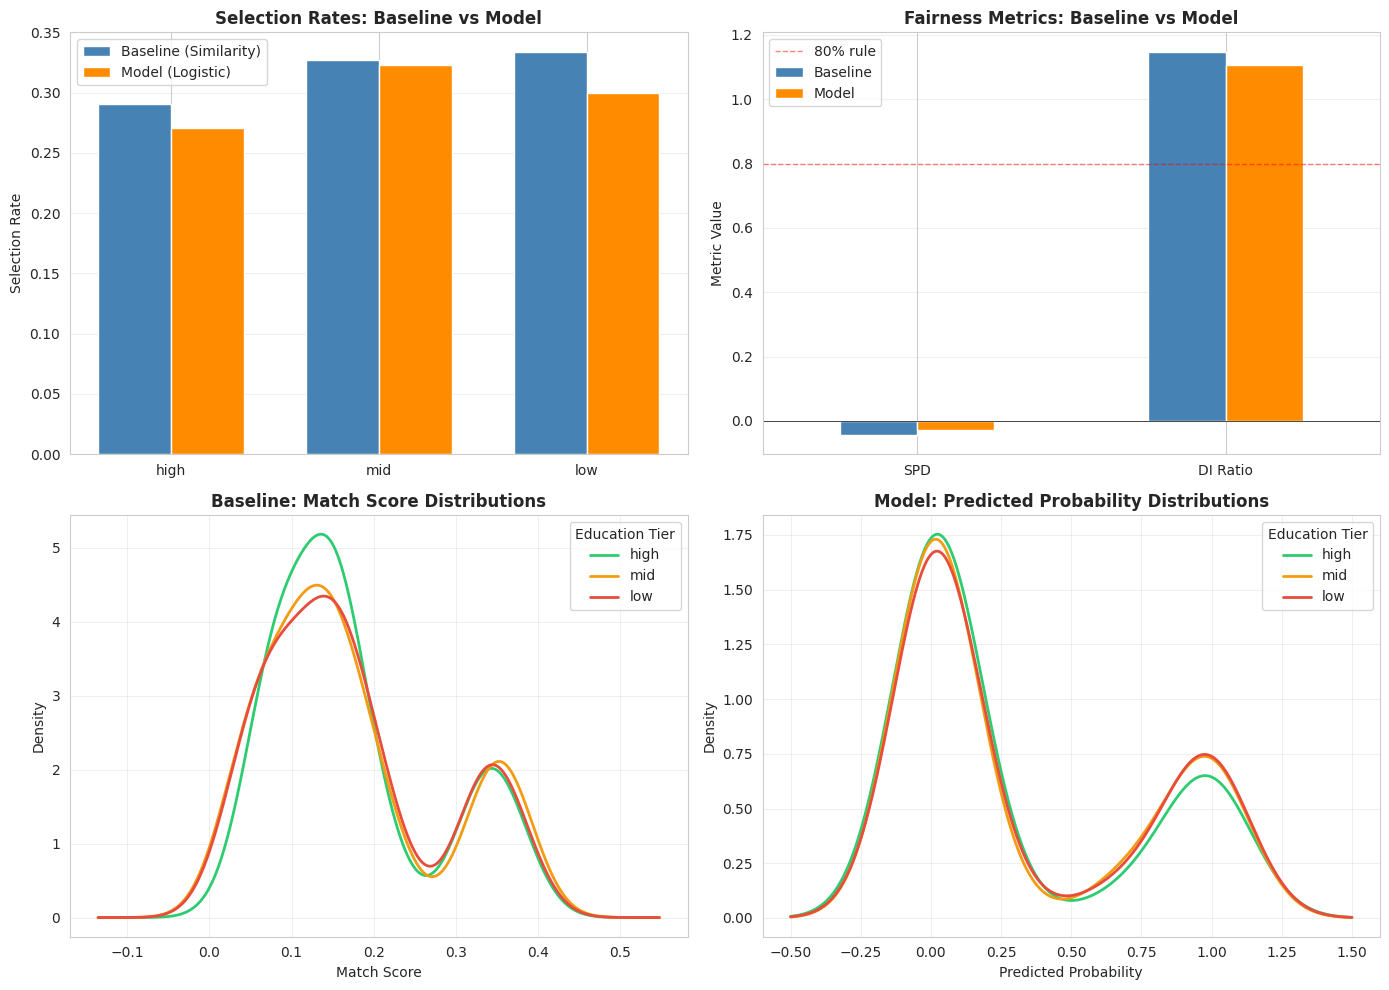


FINAL SUMMARY & INTERPRETATION

BIAS AMPLIFICATION TEST RESULTS:

1. Baseline (Similarity Only):
   - SPD: -0.0430
   - DI Ratio: 1.1481
   - Status: PASS

2. After Modeling (Logistic Regression):
   - SPD: -0.0285
   - DI Ratio: 1.1054
   - Status: PASS

3. Change (Model - Baseline):
   - ΔSPD: +0.0145
   - ΔDI: -0.0428

INTERPRETATION:

≈ MINIMAL BIAS CHANGE
  - Modeling does not significantly alter fairness metrics
  - Primary bias appears in the similarity scoring stage
  - Education-based disparities are baked into the embeddings

CRITICAL CAVEATS:
1. This is a diagnostic study, not a causal analysis
2. Education is a proxy for SES, not a perfect measure
3. Synthetic/survey data has inherent limitations
4. No claims about employer intent or discrimination
5. Results may not generalize to real hiring pipelines

WHAT THIS PROJECT DEMONSTRATES:
✓ Systematic measurement of algorithmic bias
✓ Controlled comparison across equivalence strata
✓ Rigorous fairness metric computation
✓ Unde

In [5]:
# ========================================
# NOTEBOOK 4: Modeling & Bias Amplification Test
# Run this in Google Colab after Notebook 3
# ========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# Load bias results
with open('bias_results.pkl', 'rb') as f:
    results = pickle.load(f)

df_matches = results['df_matches']
baseline_metrics = results['overall_metrics']
PRIMARY_THRESHOLD = results['primary_threshold']
outcome_col = f'high_match_{PRIMARY_THRESHOLD}'

print("✓ Loaded bias measurement results\n")

# ========================================
# PART 1: Research Question & Setup
# ========================================

print("=" * 60)
print("PART 1: Modeling Goal (Bias Amplification Test)")
print("=" * 60)

print("""
RESEARCH QUESTION:
Does adding a predictive model AMPLIFY education-based bias
compared to using similarity scores alone?

EXPLICIT NON-GOALS:
✗ We are NOT optimizing hiring accuracy
✗ We are NOT building a production screener
✗ Model performance (AUC, F1) is NOT the evaluation criterion

WHAT WE'RE TESTING:
✓ Bias amplification: does modeling make disparities worse?
✓ Pre-model vs post-model fairness metrics comparison
✓ Whether ML encodes/amplifies existing signals

METHOD:
- Baseline: similarity score only (already measured in Notebook 3)
- Model: logistic regression on [similarity + experience + role]
- Compare: SPD and DI ratio before and after modeling
""")

# ========================================
# PART 2: Feature Preparation
# ========================================

print("\n" + "=" * 60)
print("PART 2: Preparing Features (No Education Input)")
print("=" * 60)

# Prepare features (DO NOT include education as input)
features_to_use = ['match_score', 'years_experience', 'role']

# One-hot encode role
df_features = pd.get_dummies(df_matches[features_to_use], columns=['role'], drop_first=True)

# Separate features and target
X = df_features
y = df_matches[outcome_col]

# Store education tier for fairness analysis (NOT a model input)
education_tier = df_matches['education_tier']

print(f"✓ Feature matrix shape: {X.shape}")
print(f"✓ Features used: {X.columns.tolist()}")
print(f"\n⚠️  CRITICAL: 'education_tier' is NOT in the feature set")
print("   (Using it as input = discrimination by design)\n")

# Train/test split
X_train, X_test, y_train, y_test, ed_train, ed_test = train_test_split(
    X, y, education_tier, test_size=0.3, random_state=42, stratify=education_tier
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# PART 3: Train Baseline & Model
# ========================================

print("\n" + "=" * 60)
print("PART 3: Training Logistic Regression Model")
print("=" * 60)

# Train logistic regression
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Get predictions (probabilities)
y_pred_proba_train = model.predict_proba(X_train_scaled)[:, 1]
y_pred_proba_test = model.predict_proba(X_test_scaled)[:, 1]

# Convert to binary predictions using same threshold logic
# (not optimizing for accuracy, maintaining consistency with baseline)
test_threshold = np.percentile(y_pred_proba_test, 100 - PRIMARY_THRESHOLD)
y_pred_test = (y_pred_proba_test >= test_threshold).astype(int)

print(f"✓ Model trained")
print(f"\nModel coefficients (top 5):")
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', ascending=False)
print(coef_df.head())

# Performance metrics (for reference, NOT the goal)
auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nModel AUC: {auc:.4f}")
print("(Note: Performance is NOT the evaluation criterion)")

# ========================================
# PART 4: Bias Amplification Analysis
# ========================================

print("\n" + "=" * 60)
print("PART 4: Bias Amplification Analysis")
print("=" * 60)

def compute_fairness_metrics_manual(outcomes, education_tiers):
    """Compute fairness metrics for any binary outcome"""
    df_temp = pd.DataFrame({
        'outcome': outcomes,
        'education_tier': education_tiers
    })

    rates = df_temp.groupby('education_tier')['outcome'].agg(['mean', 'count'])

    high_rate = rates.loc['high', 'mean'] if 'high' in rates.index else np.nan
    low_rate = rates.loc['low', 'mean'] if 'low' in rates.index else np.nan

    spd = high_rate - low_rate
    di_ratio = low_rate / high_rate if high_rate > 0 else np.nan

    return {
        'spd': spd,
        'di_ratio': di_ratio,
        'rates': rates
    }

# Baseline metrics (similarity score only - from test set)
baseline_test_metrics = compute_fairness_metrics_manual(y_test, ed_test)

# Model metrics (logistic regression predictions)
model_test_metrics = compute_fairness_metrics_manual(y_pred_test, ed_test)

# Calculate bias amplification
spd_change = model_test_metrics['spd'] - baseline_test_metrics['spd']
di_change = model_test_metrics['di_ratio'] - baseline_test_metrics['di_ratio']

print("BASELINE (Similarity Score Only):")
print(f"  SPD (high - low): {baseline_test_metrics['spd']:.4f}")
print(f"  DI Ratio (low / high): {baseline_test_metrics['di_ratio']:.4f}")

print("\nMODEL (Logistic Regression):")
print(f"  SPD (high - low): {model_test_metrics['spd']:.4f}")
print(f"  DI Ratio (low / high): {model_test_metrics['di_ratio']:.4f}")

print("\nBIAS AMPLIFICATION:")
print(f"  ΔSPD: {spd_change:+.4f} {'(INCREASED ↑)' if spd_change > 0 else '(DECREASED ↓)'}")
print(f"  ΔDI: {di_change:+.4f} {'(WORSENED ↓)' if di_change < 0 else '(IMPROVED ↑)'}")

# Interpretation
print("\n" + "-" * 60)
if abs(spd_change) > 0.02:
    if spd_change > 0:
        print("→ FINDING: Modeling AMPLIFIES education bias")
        print("  The predictive layer increases disparities beyond similarity alone")
    else:
        print("→ FINDING: Modeling REDUCES education bias")
        print("  The predictive layer partially corrects for similarity-based disparities")
else:
    print("→ FINDING: Modeling has MINIMAL EFFECT on education bias")
    print("  Bias is primarily driven by the similarity scoring stage")

# ========================================
# PART 5: Visualizations
# ========================================

print("\n" + "=" * 60)
print("PART 5: Visualization")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Selection rates comparison
tiers = ['high', 'mid', 'low']
baseline_rates = [baseline_test_metrics['rates'].loc[t, 'mean'] if t in baseline_test_metrics['rates'].index else 0 for t in tiers]
model_rates = [model_test_metrics['rates'].loc[t, 'mean'] if t in model_test_metrics['rates'].index else 0 for t in tiers]

x = np.arange(len(tiers))
width = 0.35

axes[0, 0].bar(x - width/2, baseline_rates, width, label='Baseline (Similarity)', color='steelblue')
axes[0, 0].bar(x + width/2, model_rates, width, label='Model (Logistic)', color='darkorange')
axes[0, 0].set_title('Selection Rates: Baseline vs Model', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Selection Rate')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(tiers)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Fairness metrics comparison
metrics_comparison = pd.DataFrame({
    'Baseline': [baseline_test_metrics['spd'], baseline_test_metrics['di_ratio']],
    'Model': [model_test_metrics['spd'], model_test_metrics['di_ratio']]
}, index=['SPD', 'DI Ratio'])

metrics_comparison.plot(kind='bar', ax=axes[0, 1], color=['steelblue', 'darkorange'])
axes[0, 1].set_title('Fairness Metrics: Baseline vs Model', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Metric Value')
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0, 1].axhline(0.8, color='red', linestyle='--', linewidth=1, alpha=0.5, label='80% rule')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
plt.setp(axes[0, 1].xaxis.get_majorticklabels(), rotation=0)

# 3. Score distributions (baseline)
for tier, color in zip(tiers, ['#2ecc71', '#f39c12', '#e74c3c']):
    test_data = df_matches.loc[ed_test[ed_test == tier].index]
    if len(test_data) > 0:
        test_data['match_score'].plot.kde(ax=axes[1, 0], label=tier, linewidth=2, color=color)

axes[1, 0].set_title('Baseline: Match Score Distributions', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Match Score')
axes[1, 0].legend(title='Education Tier')
axes[1, 0].grid(alpha=0.3)

# 4. Predicted probability distributions (model)
for tier, color in zip(tiers, ['#2ecc71', '#f39c12', '#e74c3c']):
    tier_probs = y_pred_proba_test[ed_test == tier]
    if len(tier_probs) > 0:
        pd.Series(tier_probs).plot.kde(ax=axes[1, 1], label=tier, linewidth=2, color=color)

axes[1, 1].set_title('Model: Predicted Probability Distributions', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].legend(title='Education Tier')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================
# PART 6: Final Summary & Interpretation
# ========================================

print("\n" + "=" * 60)
print("FINAL SUMMARY & INTERPRETATION")
print("=" * 60)

print(f"""
BIAS AMPLIFICATION TEST RESULTS:

1. Baseline (Similarity Only):
   - SPD: {baseline_test_metrics['spd']:.4f}
   - DI Ratio: {baseline_test_metrics['di_ratio']:.4f}
   - Status: {'PASS' if baseline_test_metrics['di_ratio'] >= 0.8 else 'FAIL'}

2. After Modeling (Logistic Regression):
   - SPD: {model_test_metrics['spd']:.4f}
   - DI Ratio: {model_test_metrics['di_ratio']:.4f}
   - Status: {'PASS' if model_test_metrics['di_ratio'] >= 0.8 else 'FAIL'}

3. Change (Model - Baseline):
   - ΔSPD: {spd_change:+.4f}
   - ΔDI: {di_change:+.4f}

INTERPRETATION:
""")

if abs(spd_change) > 0.02:
    if spd_change > 0:
        print("✗ BIAS AMPLIFICATION DETECTED")
        print("  - Adding predictive modeling increases education-based disparities")
        print("  - The model encodes and amplifies bias from similarity scores")
        print("  - Suggests signals beyond pure qualification matching are being learned")
    else:
        print("✓ BIAS MITIGATION OBSERVED")
        print("  - Modeling reduces education-based disparities")
        print("  - The model learns patterns beyond surface-level credentials")
        print("  - Suggests value in multi-signal approach over similarity alone")
else:
    print("≈ MINIMAL BIAS CHANGE")
    print("  - Modeling does not significantly alter fairness metrics")
    print("  - Primary bias appears in the similarity scoring stage")
    print("  - Education-based disparities are baked into the embeddings")

print("""
CRITICAL CAVEATS:
1. This is a diagnostic study, not a causal analysis
2. Education is a proxy for SES, not a perfect measure
3. Synthetic/survey data has inherent limitations
4. No claims about employer intent or discrimination
5. Results may not generalize to real hiring pipelines

WHAT THIS PROJECT DEMONSTRATES:
✓ Systematic measurement of algorithmic bias
✓ Controlled comparison across equivalence strata
✓ Rigorous fairness metric computation
✓ Understanding of bias amplification vs mitigation

NEXT STEPS (Optional Extensions):
- Keyword analysis: what language drives disparities?
- Debiasing: test fairness-aware threshold adjustment
- Real data: validate on actual hiring outcomes
- Temporal analysis: does bias change over time?
""")

print("=" * 60)
print("PROJECT COMPLETE")
print("=" * 60)
print("All notebooks finished. Review visualizations and write up findings.")